<a href="https://colab.research.google.com/github/JLK5/humanvshorse/blob/main/horseorhuman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Selected model: efficientnetv2-b3 : https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1
Input size (300, 300)
Found 1027 files belonging to 2 classes.
Using 822 files for training.
Found 1027 files belonging to 2 classes.
Using 205 files for validation.
Building model with https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              10783528  
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 10786602 (41.15 MB)
Trainable params: 3074 (12.01 KB)
Non-trainable params: 10783528 (41.1

3/3 [==============================] - 138s 40s/step - loss: 0.6041 - accuracy: 0.7344 - val_loss: 0.4263 - val_accuracy: 0.9415
Epoch 2/5
3/3 [==============================] - 21s 7s/step - loss: 0.4095 - accuracy: 0.8906   
Epoch 3/5
3/3 [==============================] - 20s 7s/step - loss: 0.2391 - accuracy: 1.0000   
Epoch 4/5
3/3 [==============================] - 19s 7s/step - loss: 0.2284 - accuracy: 1.0000   
Epoch 5/5
3/3 [==============================] - 18s 6s/step - loss: 0.2143 - accuracy: 1.0000   


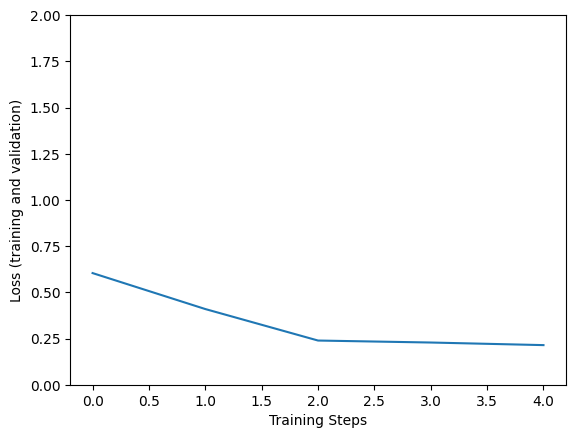

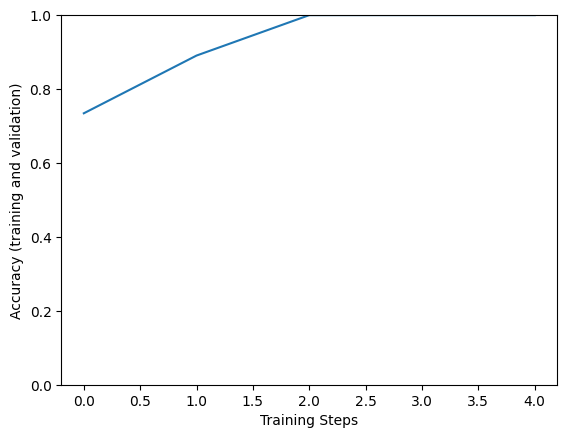

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import glob

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets.public_api as tfds



model_name = "efficientnetv2-b3"

model_handle_map = {
  "efficientnetv2-b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1"
}

model_image_size_map = {
  "efficientnetv2-b3": 300,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 300)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16

def build_dataset(subset):
  return tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/horse-or-human',
    labels='inferred',
    label_mode='categorical',
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    shuffle= True,
    seed=123,
    validation_split=.20,
    subset=subset,
)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])

train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

steps_per_epoch = train_size / BATCH_SIZE
validation_steps = valid_size / BATCH_SIZE
epochs = 5
hist = model.fit(
    train_ds,
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history



plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])


saved_model_path = f"/content/sample_data_{model_name}"
tf.saved_model.save(model, saved_model_path)

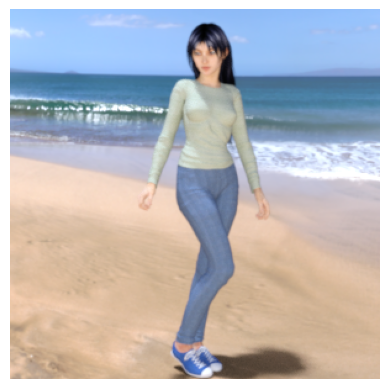

1/1 [==============================] - 3s 3s/step
True label: humans
Predicted label: humans


In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

saved_model_path = f"/content/sample_data_efficientnetv2-b3"
tf.saved_model.load(saved_model_path)

x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis = 0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])